In [1]:
# ✅ セットアップ（ライブラリインポート）

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [3]:
# ✅ モデル定義：InverseVelocityDecoder（波形→速度マップ）

In [4]:
class InverseVelocityDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, (3, 5, 3), padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1, 10, 10))
        self.fc = nn.Linear(32 * 10 * 10, 1024)
        self.out = nn.Linear(1024, 70 * 70)
        torch.nn.init.constant_(self.out.bias, 2500)  # 初期出力 = 2500 m/s

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.relu(self.out(x))  # ReLUで非負保証
        return x.view(-1, 1, 70, 70)

In [5]:
# ✅ モデル定義：WaveNet（Forward PINNでu(x,z,t)を出力）

In [6]:
class WaveNet(nn.Module):
    def __init__(self, in_dim=3, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, xzt):
        return self.net(xzt)

In [7]:
# ✅ VelocityMapFn（速度マップを連続関数化）

In [8]:
class VelocityMapFn(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, waveform, coords):
        v_grid = self.model(waveform)  # [1, 1, 70, 70]
        
        # 座標数だけv_gridを複製： [512, 1, 70, 70]
        v_grid = v_grid.expand(coords.shape[0], -1, -1, -1)
    
        coords = (coords + 1) / 2  # [-1,1] → [0,1]
        coords = coords.unsqueeze(1).unsqueeze(1)  # → [512, 1, 1, 2]
        
        return F.grid_sample(v_grid, coords, align_corners=True).view(-1, 1)


In [9]:
# ✅ PDE残差計算

In [10]:
def compute_pde_residual(u_model, v_fn, waveform, xzt, device):
    # 明示的に requires_grad と device を設定
    xzt = xzt.detach().clone().to(device).requires_grad_(True)

    # u = u(x,z,t)
    u = u_model(xzt)

    # u が grad_fn を持っているか確認
    if u.grad_fn is None:
        raise RuntimeError("u does not require grad. Check that xzt.requires_grad is True and used in the model.")

    # 勾配を計算
    grads = torch.autograd.grad(u, xzt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_z, u_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3]

    u_xx = torch.autograd.grad(u_x, xzt, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_zz = torch.autograd.grad(u_z, xzt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 1:2]
    u_tt = torch.autograd.grad(u_t, xzt, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 2:3]

    # 速度マップを座標で評価
    v = v_fn(waveform.to(device), xzt[:, :2])  # waveform も device に合わせる

    residual = u_tt - v**2 * (u_xx + u_zz)
    return residual


In [11]:
# ✅ 座標サンプラー

In [12]:
def sample_coords(batch_size):
    return 2.0 * torch.rand(batch_size, 3) - 1.0

In [13]:
# ----------------------------
# 2) Dataset 準備
# ----------------------------

import numpy as np
from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)  # shape: [N, 5, 1000, 7]
        self.vels  = np.load(vels_path)   # shape: [N, 1, 70, 70]

    def __len__(self):
        return len(self.waves)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

# パスにある .npy データをロード
train_ds = WaveformDataset("../dataset_one_batch/train_waves.npy",
                           "../dataset_one_batch/train_vels.npy")
val_ds   = WaveformDataset("../dataset_one_batch/val_waves.npy",
                           "../dataset_one_batch/val_vels.npy")

# DataLoaderの準備
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)


In [14]:
print("train_loader size:", len(train_loader))
for x, y in train_loader:
    print("Batch x shape:", x.shape)
    break

train_loader size: 100
Batch x shape: torch.Size([16, 5, 1000, 70])


In [15]:
# ✅ 学習 + 検証ループ

In [16]:
def train_forward_pinn_with_val(
    inverse_cnn, velocity_map_fn, wave_model,
    train_loader, val_loader, optimizer, device,
    epochs=100, best_model_path="best_forward_pinn_model.pth"
):
    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        inverse_cnn.train()
        wave_model.train()
        total_loss = 0.0

        for xb, _ in train_loader:
            xb = xb.to(device)
            batch_loss = 0.0

            for i in range(xb.size(0)):
                xi = xb[i].unsqueeze(0)  # [1, 5, 1000, 70]
                xzt = sample_coords(batch_size=512).to(device)
                residual = compute_pde_residual(wave_model, velocity_map_fn, xi, xzt, device)
                loss_pde = (residual ** 2).mean()
                batch_loss += loss_pde

            batch_loss /= xb.size(0)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #検証なし#
        avg_loss = avg_train_loss
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f}")

        # モデル保存（任意）
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(inverse_cnn.state_dict(), best_model_path)
            print(f"✅ Best model saved at epoch {epoch+1}")

    print("Training complete.")
    return train_losses

    #     # --- 検証ループ ---
    #     inverse_cnn.eval()
    #     wave_model.eval()
    #     val_loss = 0.0
    #     with torch.no_grad():
    #         for xb, _ in val_loader:
    #             xb = xb.to(device)
    #             for i in range(xb.size(0)):
    #                 xi = xb[i].unsqueeze(0)
    #                 xzt = sample_coords(batch_size=512).to(device)
                    
    #                 xzt = xzt.detach().clone().requires_grad_(True)
                
    #                 u = wave_model(xzt)
                
    #                 print("🧪 IN TRAIN LOOP")
    #                 print("xzt.requires_grad:", xzt.requires_grad)
    #                 print("xzt.device:", xzt.device)
    #                 print("u.device:", u.device)
    #                 print("u.grad_fn:", u.grad_fn)
                    
    #                 residual = compute_pde_residual(wave_model, velocity_map_fn, xi, xzt, device)
    #                 loss_pde = (residual ** 2).mean()
    #                 val_loss += loss_pde.item()

    #     avg_val_loss = val_loss / len(val_loader)
    #     val_losses.append(avg_val_loss)

    #     print(f"Epoch {epoch+1}/{epochs} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f}")

    #     if avg_val_loss < best_loss:
    #         best_loss = avg_val_loss
    #         torch.save(inverse_cnn.state_dict(), best_model_path)
    #         print(f"✅ Best model saved at epoch {epoch+1} with val loss {best_loss:.6f}")

    # print("Training completed.")
    # return train_losses, val_losses

In [17]:
# ----------------------------
# 3) Training 実行
# ----------------------------

# デバイスの指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの初期化
inverse_cnn = InverseVelocityDecoder().to(device)
wave_model = WaveNet().to(device)
velocity_map_fn = VelocityMapFn(inverse_cnn).to(device)

# 最適化アルゴリズム
optimizer = torch.optim.Adam(inverse_cnn.parameters(), lr=1e-3)

# 学習の実行
train_losses = train_forward_pinn_with_val(
    inverse_cnn,
    velocity_map_fn,
    wave_model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs=200,
    best_model_path="best_forward_pinn_model.pth"
)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/200 | Train Loss: 10392037917.564644
✅ Best model saved at epoch 1
Epoch 2/200 | Train Loss: 0.000828
✅ Best model saved at epoch 2
Epoch 3/200 | Train Loss: 0.000827
✅ Best model saved at epoch 3
Epoch 4/200 | Train Loss: 0.000827
Epoch 5/200 | Train Loss: 0.000827
Epoch 6/200 | Train Loss: 0.000828
Epoch 7/200 | Train Loss: 0.000827


KeyboardInterrupt: 

In [18]:
# ✅ 可視化（Loss曲線）

In [19]:
def plot_losses(train_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    # plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('PDE Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

In [20]:
plot_losses(train_losses)

NameError: name 'train_losses' is not defined

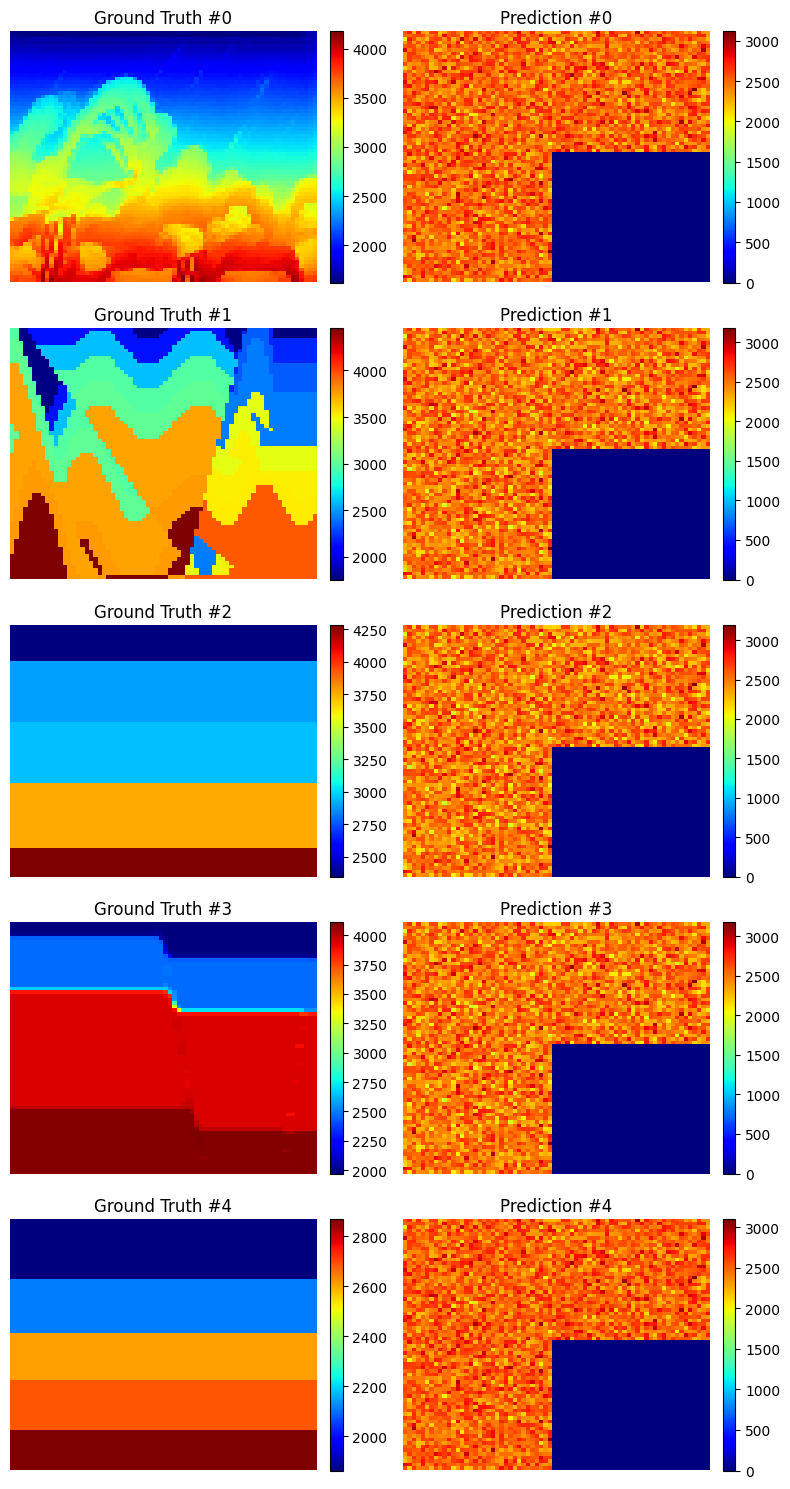

In [21]:
# ✅ 推論結果の可視化（予測 vs Ground Truth）

import matplotlib.pyplot as plt

# 推論モードに切り替え
inverse_cnn.eval()

n_show = 5  # 表示するサンプル数

with torch.no_grad():
    xb, yb = next(iter(val_loader))
    xb = xb.to(device)
    yb = yb.to(device)
    v_pred = inverse_cnn(xb)  # [B,1,70,70]

# 描画
fig, axes = plt.subplots(n_show, 2, figsize=(8, n_show * 3))

for i in range(n_show):
    pred_img = v_pred[i, 0].detach().cpu().numpy()
    gt_img   = yb[i, 0].detach().cpu().numpy()

    ax_gt = axes[i, 0]
    im_gt = ax_gt.imshow(gt_img, cmap="jet", aspect='auto')
    ax_gt.set_title(f"Ground Truth #{i}")
    fig.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
    ax_gt.axis("off")

    ax_pred = axes[i, 1]
    im_pred = ax_pred.imshow(pred_img, cmap="jet", aspect='auto')
    ax_pred.set_title(f"Prediction #{i}")
    fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
    ax_pred.axis("off")

plt.tight_layout()
plt.show()
